# 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 2. Define Global Variables

In [2]:
PATH_DATASET = 'exampleBiopsySessionDataset'

# 3. Import Biopsy Session Annotation Masks

In [3]:
mask_prostate = np.load(os.path.join(PATH_DATASET, 'mask_prostate.npy'))
print('Unique Values | Mask Prostate Gland = {}'.format(np.unique(mask_prostate)))

mask_core_pathology = np.load(os.path.join(PATH_DATASET, 'mask_label_pathology.npy'))
print('Unique Values | Mask Patholgoy Scores = {}'.format(np.unique(mask_core_pathology)))

mask_core_ids = np.load(os.path.join(PATH_DATASET, 'mask_label_core_id.npy')).astype(int)
print('Unique Values | Mask Core Ids = {}'.format(np.unique(mask_core_ids)))

Unique Values | Mask Prostate Gland = [0. 1.]
Unique Values | Mask Patholgoy Scores = [-1.  0.  2.]
Unique Values | Mask Core Ids = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


## 3.1. Visualize Needle Trajectories in 3D

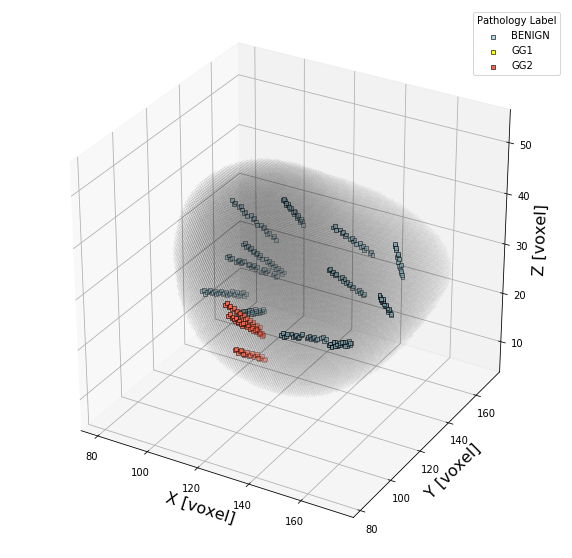

In [4]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection='3d')

pos = np.where(mask_prostate != 0)
ax.scatter(pos[0], pos[1], pos[2], c = 'black', alpha = 0.02, s = 1)

for score_, label_, color_ in zip([-1, 1, 2], ['benign', 'GG1', 'GG2'], ['lightblue', 'yellow', 'tomato']):
    pos = np.where(mask_core_pathology == score_)
    ax.scatter(pos[0], pos[1], pos[2], c = color_, label = label_.upper(), s = 15, marker = 's', edgecolor = 'k', linewidth = 0.6)

ax.set_xlabel('X [voxel]', fontsize = 16)
ax.set_ylabel('Y [voxel]', fontsize = 16)
ax.set_zlabel('Z [voxel]', fontsize = 16)

ax.legend(title = 'Pathology Label')
plt.show()

## 3.2. Visualize Needle Trajectories in 2D Orientations

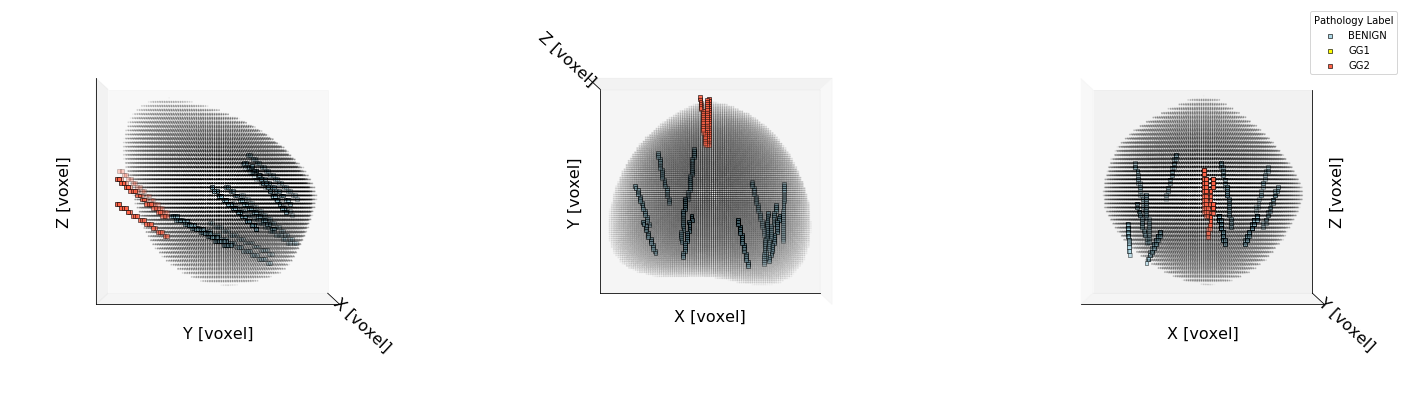

In [5]:
fig = plt.figure(figsize = (25,7))

for idx_o, orientation in enumerate([(0,0), (90,90), (0,270)]):

    ax = fig.add_subplot(1, 3, 1 + idx_o, projection='3d')
    ax.view_init(orientation[0], orientation[1])

    pos = np.where(mask_prostate != 0)
    ax.scatter(pos[0], pos[1], pos[2], c = 'black', alpha = 0.02, s = 1)

    for score_, label_, color_ in zip([-1, 1, 2], ['benign', 'GG1', 'GG2'], ['lightblue', 'yellow', 'tomato']):
        pos = np.where(mask_core_pathology == score_)
        ax.scatter(pos[0], pos[1], pos[2], c = color_, label = label_.upper(), s = 15, marker = 's', edgecolor = 'k', linewidth = 0.6)

    ax.set_xlabel('X [voxel]', fontsize = 16)
    ax.set_ylabel('Y [voxel]', fontsize = 16)
    ax.set_zlabel('Z [voxel]', fontsize = 16)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]) 
    
ax.legend(title = 'Pathology Label')
plt.show()

# 4. Create a Distance Matrix for Biopsy Cores

## 4.1. Retain Only Needle Paths Inside the Prostate Gland

In [6]:
mask_core_ids = np.where(mask_prostate != 0, mask_core_ids, 0) 

### 4.2.1 Visualize Needle Trajectories Within the Prostate in 2D Orientations

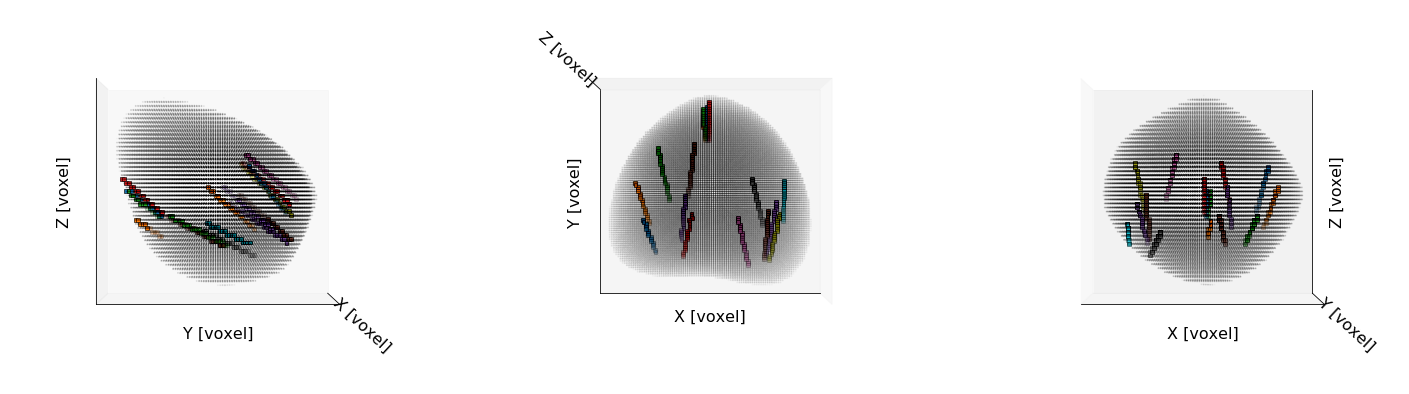

In [7]:
fig = plt.figure(figsize = (25,7))

for idx_o, orientation in enumerate([(0,0), (90,90), (0,270)]):

    ax = fig.add_subplot(1, 3, 1 + idx_o, projection='3d')
    ax.view_init(orientation[0], orientation[1])

    pos = np.where(mask_prostate != 0)
    ax.scatter(pos[0], pos[1], pos[2], c = 'black', alpha = 0.02, s = 1)

    for id_core in np.unique(mask_core_ids):
        if id_core == 0: continue
        pos = np.where(mask_core_ids == id_core)
        ax.scatter(pos[0], pos[1], pos[2], s = 15, marker = 's', edgecolor = 'k', linewidth = 0.6)

    ax.set_xlabel('X [voxel]', fontsize = 16)
    ax.set_ylabel('Y [voxel]', fontsize = 16)
    ax.set_zlabel('Z [voxel]', fontsize = 16)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([]) 
    
plt.show()

## 4.2. Retrieve Needle Path Coordinates

In [8]:
coordinates = []
for id_core in np.unique(mask_core_ids):
    if id_core == 0: continue
    coordinates_core = np.where(mask_core_ids == id_core)
    coordinates_core = pd.DataFrame(coordinates_core, index = ['x','y','z']).T
    coordinates_core['id_core'] = id_core
    coordinates.append(coordinates_core)

coordinates = pd.concat(coordinates, axis = 0).reset_index(drop = True)
coordinates

,x,y,z,id_core
0,152,155,26,1
1,152,156,25,1
2,153,152,28,1
3,153,153,27,1
4,153,154,26,1
...,...,...,...,...
323,101,156,20,16
324,101,157,19,16
325,101,158,19,16
326,101,159,18,16


## 4.3. Determine the Minimum Distance Between Each Pair of Core Biopsy Needle Paths

In [9]:
MaskVoxelSpacing = np.array([0.6640625, 0.6640625, 1.0])

distances = pdist(coordinates.drop(columns = ['id_core']).values * MaskVoxelSpacing, metric='euclidean')
dist_matrix = squareform(distances)
dist_matrix = pd.DataFrame(dist_matrix, index = coordinates['id_core'].values, columns = coordinates['id_core'].values)

distances = dist_matrix.stack().reset_index()
distances.columns = ['id_core_A', 'id_core_B', 'distance']
distances = distances.groupby(by = ['id_core_A', 'id_core_B']).min()
distances = distances.reset_index()
distances

,id_core_A,id_core_B,distance
0,1,1,0.000000
1,1,2,8.812697
2,1,3,17.751052
3,1,4,8.886306
4,1,5,9.514486
...,...,...,...
251,16,12,30.839739
252,16,13,30.093771
253,16,14,28.595451
254,16,15,1.200408


## 4.4. Transform Distance into Spatial Proximity

In [10]:
distances['proximity'] = 1 / (1 + distances['distance'])
distances

,id_core_A,id_core_B,distance,proximity
0,1,1,0.000000,1.000000
1,1,2,8.812697,0.101909
2,1,3,17.751052,0.053330
3,1,4,8.886306,0.101150
4,1,5,9.514486,0.095107
...,...,...,...,...
251,16,12,30.839739,0.031407
252,16,13,30.093771,0.032161
253,16,14,28.595451,0.033789
254,16,15,1.200408,0.454461


# 5. Generate a Matrix with One-Hot Encoded Core Pathology Scores

## 5.1. Obtain Pathology Scores from the Annotation Mask

In [11]:
core_labels = {id_core:mask_core_pathology[mask_core_ids == id_core][0] for id_core in np.unique(mask_core_ids) if id_core != 0}
core_labels = pd.DataFrame({'id_core': core_labels.keys(), 
                            'y': core_labels.values()})

print('Patholgoy Scores Legend:', end = '\n------------------------\n')
print('-1: Benign')
print('+1: GG=1')
print('+2: GG=2')

core_labels

Patholgoy Scores Legend:
------------------------
-1: Benign
+1: GG=1
+2: GG=2


,id_core,y
0,1,-1.0
1,2,-1.0
2,3,-1.0
3,4,-1.0
4,5,-1.0
5,6,-1.0
6,7,-1.0
7,8,-1.0
8,9,-1.0
9,10,-1.0


## 5.2. Convert to One-Hot Encoding

In [12]:
POSSIBLE_CLASSES = [-1,1,2]

encoder = OneHotEncoder()
encoder.fit(np.array(POSSIBLE_CLASSES).reshape(-1,1))
Y_one_hot = pd.DataFrame(encoder.transform(core_labels['y'].values.reshape(-1,1)).todense(), columns = POSSIBLE_CLASSES)
Y_one_hot['id_core'] = core_labels['id_core'].values
Y_one_hot

,-1,1,2,id_core
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,2
2,1.0,0.0,0.0,3
3,1.0,0.0,0.0,4
4,1.0,0.0,0.0,5
5,1.0,0.0,0.0,6
6,1.0,0.0,0.0,7
7,1.0,0.0,0.0,8
8,1.0,0.0,0.0,9
9,1.0,0.0,0.0,10


# 6. Utilize K-Nearest Core Pathologies for Prediction

## 6.1. Specify the Number of Neighbors

In [13]:
K = 5

## 6.2. Define the Prediction Function

In [14]:
def predict_proba_knn(id_core, distances, labels, k = 3):
    
    W = distances[(distances['id_core_A'] == id_core) &
                  (distances['id_core_B'] != id_core)]['proximity'].values


    Y = labels[labels['id_core'] != id_core].drop(columns = ['id_core']).values
    
    NEAREST_COREs_IDX = np.argsort(W)[-k:]
    w = W[NEAREST_COREs_IDX]
    w = w/np.sum(w)
    y = Y[NEAREST_COREs_IDX]
    
    y_score = np.matmul(w,y)
    
    return y_score

## 6.3. Predict

In [15]:
predict_proba_knn(id_core = 11, distances = distances, labels = Y_one_hot, k = K)

array([0.16166029, 0.        , 0.83833971])